# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `28`
* Students: `Guillain, Léonore Valentine; Pase, Francesco; Rusu, Cosmin-Ionut; Zhuang, Ying`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('adjacency.npy') # the adjacency matrix
n_nodes =  adjacency.shape[0] # the number of nodes in the network
print(n_nodes)

3179


## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
#Compute D matrix 
degrees = adjacency.sum(axis=1)
D = np.diag(degrees)

laplacian_combinatorial =  scipy.sparse.csr_matrix(D - adjacency)
#Compute D^-1/2
D_inv_sqrt = scipy.sparse.csc_matrix.sqrt(scipy.sparse.linalg.inv(scipy.sparse.csr_matrix(D)))
laplacian_normalized =  scipy.sparse.csr_matrix.dot(D_inv_sqrt, scipy.sparse.csr_matrix.dot(laplacian_combinatorial, D_inv_sqrt))

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [24]:
laplacian =  laplacian_combinatorial # Either laplacian_combinatorial or laplacian_normalized.
print(laplacian_normalized.get_shape)

<bound method spmatrix.get_shape of <3179x3179 sparse matrix of type '<class 'numpy.float64'>'
	with 40411 stored elements in Compressed Sparse Row format>>


### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [25]:
#Used numpy for all the eigenvalues
#Eigenvectors are normalized
eigenvalues, eigenvectors =  np.linalg.eig(laplacian.toarray())

indexes_sorted = np.argsort(eigenvalues)
eigenvalues_sorted = np.sort(eigenvalues)
eigenvector_sorted = eigenvectors[:,indexes_sorted]

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.**
**TO CHECK**

We use the eigensolver of numpy (and so using dense matrix) because the scipy.sparse's one revealed slower. Moreover, the method $\textit{scipy.sparse.linalg.eigs()}$ is not able no compute all the $\textit{n_nodes}$ eigenvectors.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

The matrix $S \in \mathbb{R}^{N \times M}$, where $M = |\mathcal{E}|$ and $N = |\mathcal{V}|$, is the Incidence Matrix of the (directed) graph such that:

 \begin{equation}
    S(i,j) =
    \begin{cases}
      +1, & \text{if}\ \exists k : e_j = (v_i, v_k) \in \mathcal{E} \\
      -1, & \text{if}\ \exists k : e_j = (v_k, v_i) \in \mathcal{E} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
  
If we think of $x \in \mathbb{R}^N$ as a function defined in the graph space (every vertexof the graph is a point of the Domain), the value $S^\top x \in S^M$ denotes the gradient of $x$ over the $M$ edges. Indeed $(S^\top x)_j = \sum_h S^\top(j, h) \cdot x_h =  x_i - x_k$ (where pedix $y$ denotes the the y-th element of a vector and j is the edge connecting node $i$ to $k$) is the difference of the function computed in two closed points of the graph. The direction toward which the gradient is computed is indicated by the direction of the edge connecting the nodes ($\textit{oriented Incidence Matrix}$).


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**
We can easily see that:
$$
 \| S^\top u_k \|_2^2 = < (S^\top u_k)^T, S^\top u_k > = < u_k^T S, S^\top u_k > = u_k^T SS^\top u_k = u_k^T L u_k = \lambda_k u_k^Tu_k = \lambda_k
$$
because of definition of Euclidian norm and because the eigenvectors decomposition finds orthonormal vectors.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**
By definition of Euclidian norm and answer of question 3 we have $\| S^\top x \|_2^2 = \sum_{i\sim k}(x_i - x_k)^2$ that's an indication of the smoothness of the function $x$. We can notice that, if the graph is weighted, $\| S^\top x \|_2^2 = \sum_{i\sim k}w_{i,k}(x_i - x_k)^2$, where $w_{i,k}$ is the weight of the edge j. Given this, $\| S^\top x \|_2^2 = x^TLx$ accumultes all the squared variations of the function along all the edges (positive values) given an indication of how fast the function varies over the network.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

(3179,)


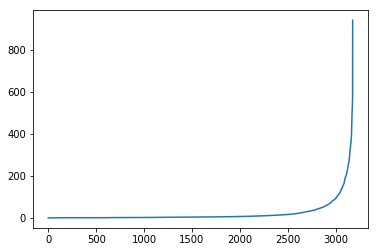

In [26]:

import networkx as nx
g = nx.Graph(adjacency)
s = nx.laplacian_spectrum(g);
print(s.shape)
plt.plot(s)

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


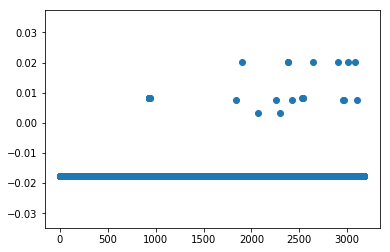

In [33]:
plt.scatter(np.arange(eigenvalues.shape[0]), eigenvector_sorted[:,0])

**Your annswer here.**

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


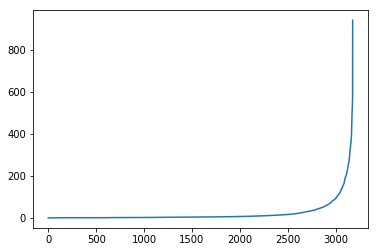

In [28]:
plt.plot( eigenvalues_sorted)

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


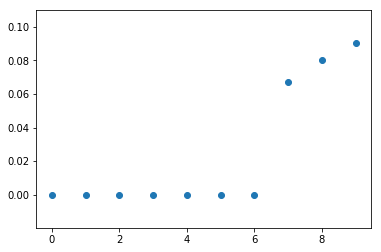

In [29]:
# Your code here.
plt.scatter(np.arange(10), eigenvalues_sorted[0:10])

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [ ]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**